In [74]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
import mne

import moabb
from moabb.datasets import BNCI2014_001
from moabb.evaluations import WithinSessionEvaluation
from moabb.evaluations import CrossSessionEvaluation
from moabb.paradigms import MotorImagery


moabb.set_log_level("info")
warnings.filterwarnings("ignore")


In [75]:
##############################################################################
# Instantiating Dataset
# ---------------------
#
# The first thing to do is to instantiate the dataset that we want to analyze.
# MOABB has a list of many different datasets, each one containing all the
# necessary information for describing them, such as the number of subjects,
# size of trials, names of classes, etc.
#
# The dataset class has methods for:
#
# - downloading its files from some online source (e.g. Zenodo)
# - importing the data from the files in whatever extension they might be
#   (like .mat, .gdf, etc.) and instantiate a Raw object from the MNE package

dataset = BNCI2014_001()
dataset.subject_list = [1, 2, 3]

In [76]:
##############################################################################
# Accessing EEG Recording
# -----------------------
#
# As an example, we may access the EEG recording from a given session and a
# given run as follows:

sessions = dataset.get_data(subjects=[1])

##############################################################################
# This returns a MNE Raw object that can be manipulated. This might be enough
# for some users, since the pre-processing and epoching steps can be easily
# done via MNE. However, to conduct an assessment of several classifiers on
# multiple subjects, MOABB ends up being a more appropriate option.

subject = 1
session_name = "0train"
run_name = "0"
raw = sessions[subject][session_name][run_name]

In [77]:
##############################################################################
# For the example below, we will consider the paradigm associated to
# left-hand/right-hand motor imagery task, but there are other options in
# MOABB for motor imagery, P300 or SSVEP.

paradigm = MotorImagery()


2024-06-03 20:06:23,303 WARNING MainThread moabb.paradigms.motor_imagery Choosing from all possible events


In [78]:
print(paradigm.__doc__) 

N-class motor imagery.

    Metric is 'roc-auc' if 2 classes and 'accuracy' if more

    Parameters
    -----------

    events: List of str
        event labels used to filter datasets (e.g. if only motor imagery is
        desired).

    n_classes: int,
        number of classes each dataset must have. If events is given,
        requires all imagery sorts to be within the events list.

    fmin: float (default 8)
        cutoff frequency (Hz) for the high pass filter

    fmax: float (default 32)
        cutoff frequency (Hz) for the low pass filter

    tmin: float (default 0.0)
        Start time (in second) of the epoch, relative to the dataset specific
        task interval e.g. tmin = 1 would mean the epoch will start 1 second
        after the beginning of the task as defined by the dataset.

    tmax: float | None, (default None)
        End time (in second) of the epoch, relative to the beginning of the
        dataset specific task interval. tmax = 5 would mean the epoch wi

In [80]:
print(paradigm.get_data(dataset=dataset, subjects=[1]))

['tongue' 'feet' 'right_hand' 'left_hand' 'left_hand' 'right_hand' 'feet'
 'tongue' 'right_hand' 'feet' 'left_hand' 'left_hand' 'left_hand' 'tongue'
 'right_hand' 'right_hand' 'left_hand' 'left_hand' 'feet' 'left_hand'
 'right_hand' 'tongue' 'tongue' 'feet' 'left_hand' 'tongue' 'tongue'
 'right_hand' 'tongue' 'tongue' 'right_hand' 'left_hand' 'right_hand'
 'feet' 'feet' 'feet' 'tongue' 'feet' 'left_hand' 'tongue' 'right_hand'
 'feet' 'right_hand' 'feet' 'tongue' 'right_hand' 'feet' 'left_hand'
 'left_hand' 'left_hand' 'tongue' 'right_hand' 'left_hand' 'feet'
 'left_hand' 'feet' 'right_hand' 'tongue' 'left_hand' 'feet' 'feet'
 'left_hand' 'feet' 'right_hand' 'tongue' 'tongue' 'tongue' 'feet'
 'left_hand' 'tongue' 'right_hand' 'tongue' 'right_hand' 'left_hand'
 'feet' 'right_hand' 'left_hand' 'feet' 'feet' 'left_hand' 'feet' 'tongue'
 'tongue' 'right_hand' 'left_hand' 'right_hand' 'tongue' 'right_hand'
 'tongue' 'feet' 'right_hand' 'right_hand' 'right_hand' 'feet' 'tongue'
 'left_hand' '

In [81]:
##############################################################################
# The data from a list of subjects could be preprocessed and return as a 3D
# numpy array `X`, follow a scikit-like format with the associated `labels`.
# The `meta` object contains all information regarding the subject, the
# session and the run associated to each trial.
X, labels, meta = paradigm.get_data(dataset=dataset, subjects=[1])

In [83]:
print(X.shape, labels.shape, meta)

(576, 22, 1001) (576,)      subject session run
0          1  0train   0
1          1  0train   0
2          1  0train   0
3          1  0train   0
4          1  0train   0
..       ...     ...  ..
571        1   1test   5
572        1   1test   5
573        1   1test   5
574        1   1test   5
575        1   1test   5

[576 rows x 3 columns]


In [84]:
##############################################################################
# Create Pipeline
# ---------------
#
# Our goal is to evaluate the performance of a given classification pipeline
# (or several of them) when it is applied to the epochs from the previously
# chosen dataset. We will consider a very simple classification pipeline in
# which the dimension of the epochs are reduced via a CSP step and then
# classified via a linear discriminant analysis.

pipeline = make_pipeline(CSP(n_components=8), LDA())

In [85]:
##############################################################################
# Evaluation
# ----------
#
# To evaluate the score of this pipeline, we use the `evaluation` class. When
# instantiating it, we say which paradigm we want to consider, a list with the
# datasets to analyze, and whether the scores should be recalculated each time
# we run the evaluation or if MOABB should create a cache file.
#
# Note that there are different ways of evaluating a classifier; in this
# example, we choose `WithinSessionEvaluation`, which consists of doing a
# cross-validation procedure where the training and testing partitions are from
# the same recording session of the dataset. We could have used
# `CrossSessionEvaluation`, which takes all but one session as training
# partition and the remaining one as testing partition.

evaluation = WithinSessionEvaluation(
    paradigm=paradigm,
    datasets=[dataset],
    overwrite=True,
    hdf5_path=None,
)



In [86]:
##############################################################################
# We obtain the results in the form of a pandas dataframe

results = evaluation.process({"csp+lda": pipeline})

2024-06-03 20:08:40,882 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-001
BNCI2014-001-WithinSession:   0%|          | 0/3 [00:00<?, ?it/s]

No hdf5_path provided, models will not be saved.


2024-06-03 20:08:59,881 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 1 | 0train: Score 0.736


No hdf5_path provided, models will not be saved.


2024-06-03 20:09:08,754 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 1 | 1test: Score 0.743
BNCI2014-001-WithinSession:  33%|███▎      | 1/3 [00:28<00:57, 28.54s/it]

No hdf5_path provided, models will not be saved.


2024-06-03 20:09:28,186 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 2 | 0train: Score 0.684


No hdf5_path provided, models will not be saved.


2024-06-03 20:09:35,566 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 2 | 1test: Score 0.604
BNCI2014-001-WithinSession:  67%|██████▋   | 2/3 [00:55<00:27, 27.50s/it]

No hdf5_path provided, models will not be saved.


2024-06-03 20:09:51,457 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 3 | 0train: Score 0.844


No hdf5_path provided, models will not be saved.


2024-06-03 20:09:59,674 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 3 | 1test: Score 0.858
BNCI2014-001-WithinSession: 100%|██████████| 3/3 [01:19<00:00, 26.49s/it]


In [87]:
##############################################################################
# The results are stored in locally, to avoid recomputing the results each time.
# It is saved in `hdf5_path` if defined or in ~/mne_data/results  otherwise.
# To export the results in CSV:

results.to_csv("./results_part2-1.csv")

##############################################################################
# To load previously obtained results saved in CSV

results = pd.read_csv("./results_part2-1.csv")



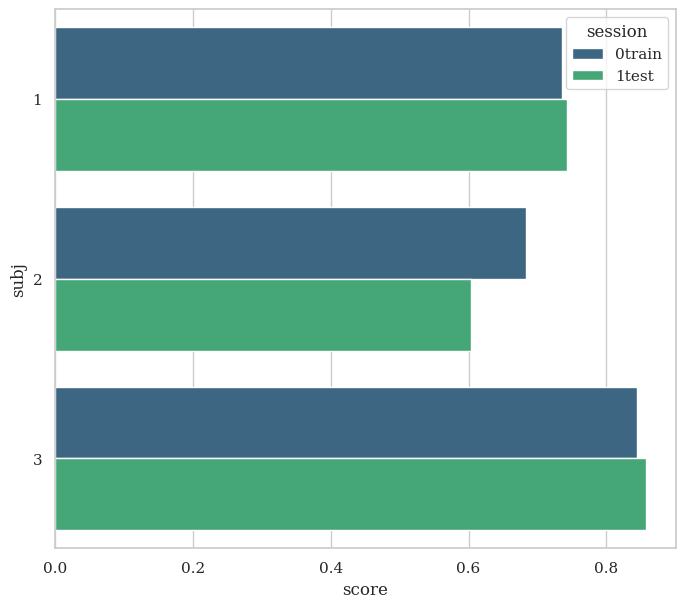

In [88]:
##############################################################################
# Plotting Results
# ----------------
#
# We create a figure with the seaborn package comparing the classification
# score for each subject on each session. Note that the 'subject' field from
# the `results` is given in terms of integers, but seaborn accepts only
# strings for its labeling. This is why we create the field 'subj'.

fig, ax = plt.subplots(figsize=(8, 7))
results["subj"] = results["subject"].apply(str)
sns.barplot(
    x="score", y="subj", hue="session", data=results, orient="h", palette="viridis", ax=ax
)
plt.show()